In [72]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [73]:
batch_size = 64
num_classes = 10
learning_rate = 10e-3
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = 64, # TEST BATCH SIZE
                                           shuffle = True)

In [75]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [6]:
LeNet = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(LeNet.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [ ]:
# LENET TRAINING
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = LeNet(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Source for LeNet: https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/

In [ ]:
# SAVE TRAINED MODEL
torch.save(LeNet, 'LeNet.pth')

In [76]:
# LOAD FROM SAVED FILE
LeNet = torch.load('LeNet.pth')
LeNet.eval()

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (relu): ReLU()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

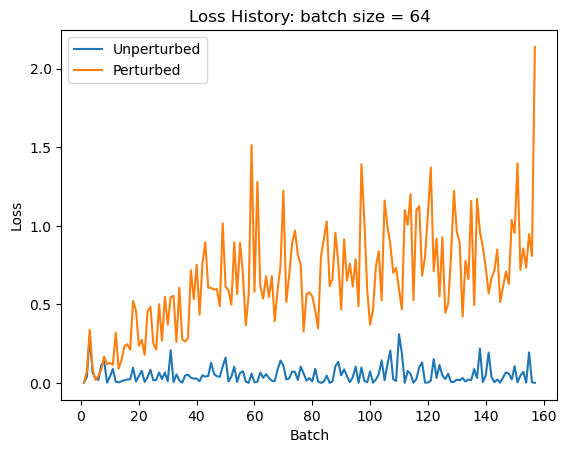

In [27]:
# TEST ITERATIVE FSGM white-box attack
eps = 0.3
step_size = 0.1
criterion = torch.nn.CrossEntropyLoss()
loss_hist = []
loss_perb_hist = []
perb = torch.zeros((32,32), requires_grad=True)
for a, l in test_loader:
    outputs = LeNet(a + perb)
    loss_perb = criterion(outputs, l)  # where criterion might be cross-entropy loss
    loss_perb.backward()
    perb.data += step_size * perb.grad.sign()
    #projection
    perb.data = torch.clamp(perb.data, -eps, eps)
    loss = criterion(LeNet(a), l)
    loss_hist.append(loss.item())
    loss_perb_hist.append(loss_perb.item())

batches = range(1, len(loss_hist) + 1)
plt.plot(batches, loss_hist, label='Unperturbed')
plt.plot(batches, loss_perb_hist, label='Perturbed')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title(f'Loss History: batch size = {batch_size}')
plt.legend()
plt.show()

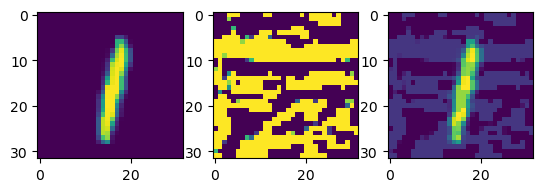

In [28]:
plt.subplot(1, 3, 1)
plt.imshow(a[0].squeeze())
plt.subplot(1, 3, 2)
plt.imshow(perb.detach().numpy())
plt.subplot(1, 3, 3)
plt.imshow(a[0].squeeze() + perb.detach().numpy())

In [80]:
# TEST FIRST ORDER (WHITE-BOX) FRANK-WOLFE
def grad(model, x, perb, l, criterion):
    outputs = model(x + perb)
    loss_perb = criterion(outputs, l)  # where criterion might be cross-entropy loss
    loss_perb.backward()
    return perb.grad.sign()

def frank_wolfe(): # Not STOCHASTIC, STANDARD FW
    num_iterations = 10 # T
    criterion = torch.nn.CrossEntropyLoss()
    gamma = 0.1 # Step size
    Beta = 0.3 # gradient weight parmaeter
    perb = torch.zeros((32,32), requires_grad= True) # DISABLE GRAD for BLACK-BOX implementation
    m = torch.zeros_like(perb, requires_grad= True)
    for t in range(1, num_iterations + 1):
        for a,l in torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size=len(test_dataset), # ENTIRE set, one batch
                                        shuffle = True):
            # Chen et al. formulation
            #print(len(a))
            if perb.grad:
                perb.grad.zero_()
            q = grad(LeNet, a, perb, l, criterion)
            #print(q)
            if t == 0:
                m = q
            m = Beta * m + (1 - Beta) * q # weighted gradient update - provides smoothing
            q = m
            # LINEAR MINIMIZATION ORCALE STEP (LMO)
            coord = torch.argmax(q.abs())
            v = torch.zeros_like(q)
            theta = 0.1 # ???
            v[coord] = - theta * torch.sign(q[coord])
            d = v - perb
            perb = perb + gamma * d
            #print(torch.norm(perb))
            
            # Heung et al. formulation
            '''
            # LEO step
            w = torch.argmax()
            # convex combination step
            perb = (1 - gamma) * perb + gamma * w
            '''
    return perb


In [81]:

def SZOFW(N, d, s, m_k, x, y_true_in, model, v=-1, alpha=-1, B=1, verbose=True, clip=False):
    device = x.device  # Assuming x is already a PyTorch tensor

    if v == -1:
        v = sqrt(2 / (N * (d + 3)**3))
    if alpha == -1:
        alpha = 1 / torch.sqrt(torch.tensor(N, dtype=torch.float32))

    x_ori = x.clone()
    loss_ZSCG = []
    perturbations = []
    loss_ZSCG.append(F_torch(x, y_true_in, model))

    if verbose:
        print("Epoch:", 0, "Loss:", F_torch(x_ori, y_true_in, model).item(), "Distortion:", torch.max(torch.abs(x - x_ori)).item())
    for k in range(N):
        v_k = 0
        for i in tqdm(range(x.shape[0]), disable= not verbose):
            v_k += Avg_RandGradEst(x[i:i+1], y_true_in[i:i+1], m_k, v, 32, model)
            #v_k += Avg_RandGradEst_Par(x[i:i+1], y_true_in[i:i+1], m_k, v, d, model)

        v_k = (1 / x.shape[0]) * v_k

        x_k = -s * torch.sign(v_k) + x_ori 
        x = (1 - alpha) * x + alpha * x_k
        if clip:
            x = x_ori + torch.clamp((x - x_ori), 0, 1)
        perturbations.append(x)
        loss_ZSCG.append(F_torch(x, y_true_in, model).item())
        if verbose:
            print("-"*100)
            print("Epoch:", k+1, "Loss:", loss_ZSCG[k], "Distortion:", torch.max(torch.abs(x - x_ori)).item())
        if stop_attack(x, y_true_in, model):  # Assuming this function handles PyTorch tensors
            print("Attack successful! stopping computation...")
            return loss_ZSCG, x

    ZSCG_x_perturbated = x
    print("ZSCG Final loss =", loss_ZSCG[-1])
    return loss_ZSCG, ZSCG_x_perturbated, perturbations


C:\Users\JIC\AppData\Local\Temp\ipykernel_20684\1168598483.py:21: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\build\aten\src\ATen/core/TensorBody.h:491.)
  if perb.grad:
C:\Users\JIC\AppData\Local\Temp\ipykernel_20684\1168598483.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf

AttributeError: 'NoneType' object has no attribute 'sign'